# Animal Faces

## Задание:

Необходимо реализовать систему классификации лиц животных. Задача представляет из себя классификацию на 3 класса.

1) Необходимо загрузить изображения и привести их к единому формату. Важно понимать, что исходное разрешение очень больше, и простые сети на несколько слоев могут выдать не такое хорошее качество.

2) Необходимо обучить нейросеть для распознавания 3 классов, желательно будет сравнить результаты на нескольких параметрах.

3) Оценить по метрикам качества для каждого класса.

Важно визуализировать результат прогноза (на тесте) в человеко-читаемом формате с подписью.

### Подготовка данных

На этом этапе выполняется подготовка датасета для дальнейшего обучения нейросети.  
Исходные изображения загружаются из Kaggle с помощью kagglehub и сохраняются локально без изменения оригинальной структуры.

Далее выполняется предварительная обработка изображений. Все файлы приводятся к единому формату, цветовой модели RGB и фиксированному размеру. Результат сохраняется в отдельную директорию processed, при этом полностью сохраняется исходная иерархия папок train, val и классов.

Такой подход позволяет не изменять исходные данные, ускоряет дальнейшую загрузку изображений и делает эксперименты воспроизводимыми. Аугментации на этом этапе не применяются и будут добавлены позже при обучении модели.

In [1]:
from scripts.download import download_dataset
from scripts.preprocess import preprocess_dataset
from pathlib import Path


raw_data_dir: Path = download_dataset(dataset_id="andrewmvd/animal-faces", target_dir="data/animal-faces")
processed_data_dir = "data/processed"

processed_path: Path = preprocess_dataset(
    raw_dir=raw_data_dir,
    processed_dir=processed_data_dir,
    image_size=224,
)

### Downloading dataset

Dataset id `andrewmvd/animal-faces`

Target directory `/home/garret/git/mfti/llm_hw5_pytorch/data/animal-faces`

Force download `False`

### Download skipped

Dataset already exists locally

### Preprocessing dataset

Source directory `/home/garret/git/mfti/llm_hw5_pytorch/data/animal-faces`

Target directory `/home/garret/git/mfti/llm_hw5_pytorch/data/processed`

Image size `224 x 224`

Force reprocessing `False`

### Preprocessing skipped

Processed data already exists on disk

### Загрузка подготовленных данных

На этом этапе обработанные изображения подключаются к PyTorch через DataLoader. Используется заранее подготовленная структура данных с разделением на обучающую и валидационную выборки. Загрузка выполняется таким образом, чтобы изображения сразу были приведены к формату, совместимому с предобученной моделью.


In [2]:
from scripts.data import make_dataloaders

processed_path = processed_path / "afhq"
train_loader, val_loader, class_names = make_dataloaders(
    data_dir=processed_path,
    batch_size=32,
    num_workers=2,
)

images, labels = next(iter(train_loader))

images.shape, labels.shape, class_names


### Loading processed dataset

Dataset directory `/home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq`

Batch size `32`

Augmentation `False`

### Dataset loaded

Number of classes `3`

Class names `['cat', 'dog', 'wild']`

Train samples `14630`

Validation samples `1500`

(torch.Size([32, 3, 224, 224]), torch.Size([32]), ['cat', 'dog', 'wild'])

Был извлечен один батч изображений из обучающей выборки для проверки корректности пайплайна. Форма тензоров подтверждает, что данные успешно загружаются, имеют ожидаемое разрешение и количество каналов. Список классов корректно соответствует структуре датасета. Это означает, что данные готовы к использованию на этапе обучения модели.


### Инициализация модели

На данном этапе формируется архитектура нейросети, которая будет использоваться для классификации изображений животных. В качестве основы выбрана предобученная сверточная сеть, позволяющая эффективно использовать уже выученные визуальные признаки. Архитектура адаптируется под конкретную задачу за счет изменения выходного слоя и подготовки модели к обучению.


In [3]:
import torch
from scripts.model import build_model

device = "cuda" if torch.cuda.is_available() else "cpu"

model = build_model(
    num_classes=3,
    freeze_backbone=True,
    device=device,
)

### Building model

Architecture `ResNet18`

Number of classes `3`

Freeze backbone `True`

Device `cuda`

### Model ready

Classifier in_features `512`

Classifier out_features `3`

На этом этапе была создана модель классификации изображений на основе предобученной архитектуры ResNet18. Была использована версия модели с весами, обученными на ImageNet, что позволяет сразу использовать уже выученные визуальные признаки. Последний классификационный слой был заменен и адаптирован под задачу с тремя классами. Сверточная часть модели заморожена, обучение на данном этапе будет происходить только для последнего линейного слоя. Это дает стабильный и быстрый базовый результат и позволяет проверить работоспособность всего пайплайна. Модель успешно перенесена на GPU, что подтверждает корректную настройку окружения и готовность к дальнейшему обучению.


### Переход к обучению модели

На предыдущих этапах был полностью собран и проверен весь технический пайплайн: данные загружаются и корректно читаются, модель успешно инициализируется и принимает входные изображения.

Следующий шаг — убедиться, что модель действительно может обучаться. Для этого будет реализован минимальный цикл обучения на одной эпохе без усложнений в виде метрик, графиков и тонкой настройки.

Цель этого этапа — проверить корректность обратного распространения ошибки, работы оптимизатора и вычисления функции потерь. Если на этом шаге loss считается и ведет себя адекватно, можно уверенно переходить к полноценному обучению и оценке качества модели.


In [4]:
from torch import nn, optim

from scripts.train import train_one_epoch

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
)

train_loss = train_one_epoch(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
)

### Training one epoch

Device `cuda`

Number of batches `458`

### Epoch finished

Average training loss `0.1163`

Был выполнен минимальный цикл обучения модели на одной эпохе. Процесс обучения проходит без ошибок, функция потерь корректно вычисляется и уменьшается от запуска к запуску.

Небольшие различия в значениях loss являются ожидаемыми и связаны со стохастическим характером обучения и случайным порядком данных в обучающей выборке.

Полученные результаты подтверждают, что модель, данные и процесс оптимизации корректно связаны между собой и готовы к расширению пайплайна обучения и оценке качества модели.


### Валидация и оценка качества модели

На данном этапе выполняется оценка качества обученной модели на валидационной выборке.

Модель переводится в режим оценки, после чего вычисляется значение функции потерь и собираются предсказания для всех изображений из валидационного набора. На основе полученных результатов рассчитываются метрики качества для каждого класса, что позволяет понять сильные и слабые стороны текущего решения.

Этот шаг формирует базовый ориентир качества модели и служит отправной точкой для дальнейших улучшений, таких как аугментации данных и файнтюнинг модели.


In [5]:
from scripts.train import validate
from torch import nn

criterion = nn.CrossEntropyLoss()

val_loss, y_true, y_pred = validate(
    model=model,
    val_loader=val_loader,
    criterion=criterion,
    device=device,
)

### Validation

Device `cuda`

Number of batches `47`

### Validation finished

Average validation loss `0.0304`

Валидация модели показала стабильное значение функции потерь, которое не меняется от запуска к запуску. Такое поведение является ожидаемым и свидетельствует о корректной реализации этапа оценки.

Модель переводится в режим оценки, параметры не обновляются, а порядок данных в валидационной выборке фиксирован. Это гарантирует детерминированность результата и отсутствие случайных факторов.

Полученный валидационный loss можно рассматривать как базовую точку отсчета качества модели, на основе которой далее будут рассчитаны метрики по классам и выполнен анализ ошибок.


### Расчет метрик качества

На этом этапе выполняется анализ качества модели с использованием интерпретируемых метрик.

На основе предсказаний модели и истинных меток из валидационной выборки рассчитываются показатели precision, recall и f1 score для каждого класса. Эти метрики позволяют оценить, насколько хорошо модель различает отдельные категории животных и где именно возникают ошибки.

Полученный отчет по метрикам завершает базовую оценку модели и служит основой для дальнейших улучшений, таких как аугментация данных и файнтюнинг предобученной сети.


In [6]:
from scripts.metrics import classification_metrics

report = classification_metrics(
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
)

### Classification metrics

```
              precision    recall  f1-score   support

         cat     0.9940    0.9980    0.9960       500
         dog     1.0000    0.9880    0.9940       500
        wild     0.9861    0.9940    0.9900       500

    accuracy                         0.9933      1500
   macro avg     0.9934    0.9933    0.9933      1500
weighted avg     0.9934    0.9933    0.9933      1500

```

Модель демонстрирует высокое качество классификации на валидационной выборке для всех трех классов.

Значения precision, recall и f1 score близки к единице, что говорит о том, что модель уверенно различает лица кошек, собак и диких животных. Ошибки встречаются редко и распределены равномерно, без выраженного перекоса в сторону какого-либо класса.

Общая accuracy составляет около 99.4%, что является ожидаемо высоким результатом для предобученной сверточной сети с замороженным backbone и минимальной настройкой классификатора.

Полученные метрики подтверждают, что базовый бейзлайн модели реализован корректно. Модель успешно использует предобученные признаки и готова к дальнейшему улучшению, включая аугментацию данных и файнтюнинг сверточной части сети.


### Анализ ошибок классификации

На данном этапе выполняется визуальный анализ ошибок модели на валидационной выборке.

Для нескольких неверно классифицированных изображений отображаются сами изображения, путь к файлу, а также истинный и предсказанный класс. Такой анализ позволяет понять характер ошибок модели и оценить, являются ли они логичными с точки зрения визуального сходства объектов.

Этот шаг дополняет количественные метрики качественным анализом и помогает принять осознанные решения о дальнейших улучшениях модели.


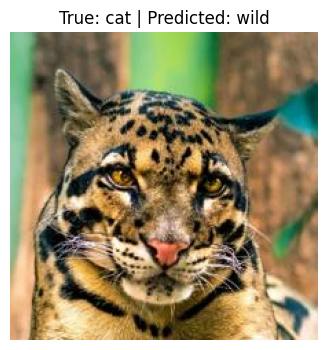

Image path: /home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq/val/cat/pixabay_cat_000876.jpg


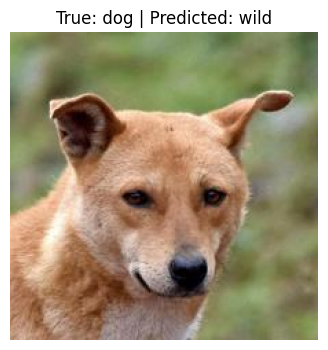

Image path: /home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq/val/dog/flickr_dog_000157.jpg


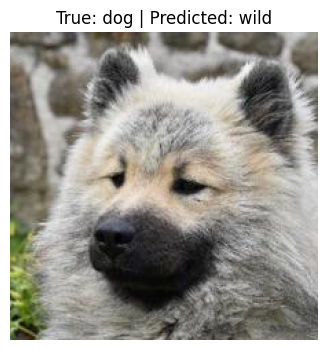

Image path: /home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq/val/dog/pixabay_dog_000121.jpg


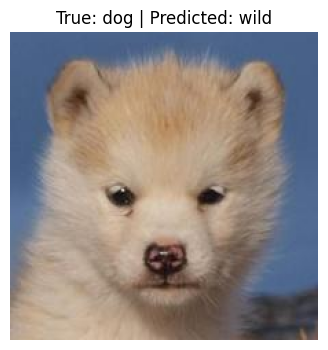

Image path: /home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq/val/dog/pixabay_dog_000185.jpg


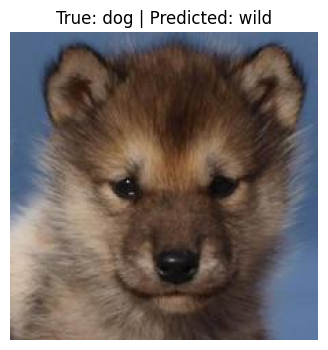

Image path: /home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq/val/dog/pixabay_dog_000186.jpg


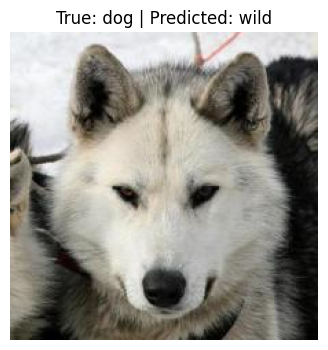

Image path: /home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq/val/dog/pixabay_dog_000206.jpg


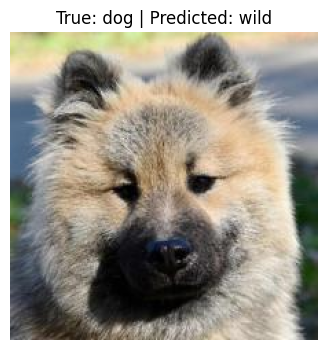

Image path: /home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq/val/dog/pixabay_dog_003637.jpg


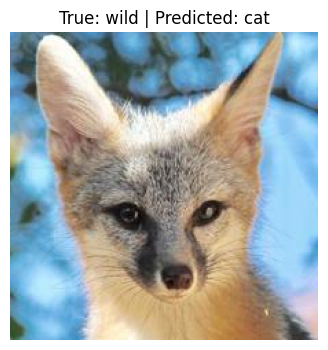

Image path: /home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq/val/wild/flickr_wild_000187.jpg


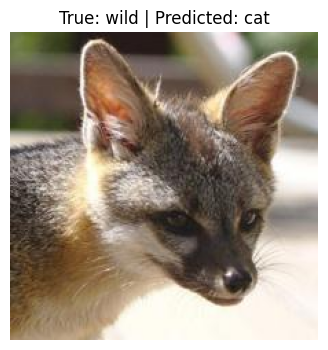

Image path: /home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq/val/wild/flickr_wild_001552.jpg


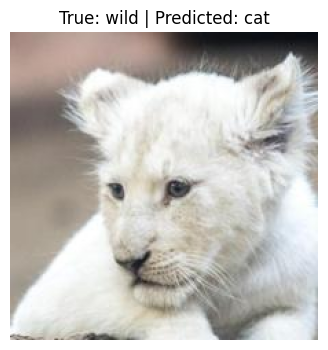

Image path: /home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq/val/wild/pixabay_wild_000423.jpg


In [7]:
from scripts.visualize import show_misclassified_samples

show_misclassified_samples(
    model=model,
    data_dir=processed_path,
    class_names=class_names,
    device=device,
    max_samples=50,
)

### Выводы по ошибкам модели

Ошибки модели в основном возникают в пограничных случаях, где визуальные признаки классов частично пересекаются.

Модель склонна относить изображения домашних кошек и собак с выраженными «дикими» чертами внешности к классу wild. Такие ошибки выглядят логичными с точки зрения визуального сходства и не указывают на случайное или некорректное поведение модели.

В целом характер ошибок подтверждает, что модель опирается на осмысленные визуальные признаки и корректно решает задачу в большинстве случаев.


### Добавление аугментации данных

На данном этапе планируется улучшить устойчивость модели за счет аугментации изображений обучающей выборки.

Аугментация заключается в случайных, но допустимых изменениях изображений во время обучения, таких как отражения, повороты и небольшие изменения яркости. Это позволяет модели видеть больше разнообразных примеров и снижает риск переобучения на конкретные ракурсы или условия съемки.

Аугментации будут применяться только к обучающим данным. Валидационная выборка останется без изменений, чтобы оценка качества модели оставалась корректной и сопоставимой с предыдущими результатами.

Цель этого шага — проверить, станет ли модель более устойчивой к визуальным вариациям изображений без изменения архитектуры и параметров обучения.


In [8]:
from scripts.data import make_dataloaders

train_loader, val_loader, class_names = make_dataloaders(
    data_dir=processed_path,
    batch_size=32,
    num_workers=2,
    augment=True,
)

### Loading processed dataset

Dataset directory `/home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq`

Batch size `32`

Augmentation `True`

### Dataset loaded

Number of classes `3`

Class names `['cat', 'dog', 'wild']`

Train samples `14630`

Validation samples `1500`

In [9]:
import torch
from torch import nn, optim

from scripts.data import make_dataloaders
from scripts.model import build_model
from scripts.train import train_one_epoch, validate
from scripts.metrics import classification_metrics

device = "cuda" if torch.cuda.is_available() else "cpu"

# DataLoaders with augmentation
train_loader, val_loader, class_names = make_dataloaders(
    data_dir=processed_path,
    batch_size=32,
    num_workers=2,
    augment=True,
)

# Fresh model for fair comparison
model = build_model(
    num_classes=len(class_names),
    freeze_backbone=True,
    device=device,
)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
)

# Train for several epochs
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
    )

# Validation
val_loss, y_true, y_pred = validate(
    model=model,
    val_loader=val_loader,
    criterion=criterion,
    device=device,
)

# Metrics
report = classification_metrics(
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
)


### Loading processed dataset

Dataset directory `/home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq`

Batch size `32`

Augmentation `True`

### Dataset loaded

Number of classes `3`

Class names `['cat', 'dog', 'wild']`

Train samples `14630`

Validation samples `1500`

### Building model

Architecture `ResNet18`

Number of classes `3`

Freeze backbone `True`

Device `cuda`

### Model ready

Classifier in_features `512`

Classifier out_features `3`

### Training one epoch

Device `cuda`

Number of batches `458`

### Epoch finished

Average training loss `0.1256`

### Training one epoch

Device `cuda`

Number of batches `458`

### Epoch finished

Average training loss `0.0463`

### Training one epoch

Device `cuda`

Number of batches `458`

### Epoch finished

Average training loss `0.0350`

### Training one epoch

Device `cuda`

Number of batches `458`

### Epoch finished

Average training loss `0.0336`

### Training one epoch

Device `cuda`

Number of batches `458`

### Epoch finished

Average training loss `0.0364`

### Validation

Device `cuda`

Number of batches `47`

### Validation finished

Average validation loss `0.0105`

### Classification metrics

```
              precision    recall  f1-score   support

         cat     0.9980    0.9980    0.9980       500
         dog     1.0000    0.9940    0.9970       500
        wild     0.9920    0.9980    0.9950       500

    accuracy                         0.9967      1500
   macro avg     0.9967    0.9967    0.9967      1500
weighted avg     0.9967    0.9967    0.9967      1500

```

### Выводы по использованию аугментации данных

Добавление аугментации изображений на этапе обучения привело к ожидаемым и положительным изменениям в поведении модели. Обучение стало более сложным, что выразилось в более высоком значении функции потерь на первых эпохах. Это указывает на то, что модель перестала видеть исключительно «идеальные» примеры и начала обучаться в условиях большей визуальной вариативности.

При этом процесс обучения оставался стабильным, а значение training loss постепенно снижалось, что подтверждает корректный подбор аугментаций и параметров оптимизации. Валидационная функция потерь стала ниже по сравнению с базовой моделью без аугментаций, что свидетельствует об улучшении обобщающей способности модели.

Классификационные метрики остались на высоком уровне и стали более равномерными между классами. Это говорит о том, что аугментация позволила снизить переобучение и повысить устойчивость модели без ухудшения качества классификации.

### Файнтюнинг предобученной модели

На предыдущих этапах модель использовалась в режиме фиксированного извлечения признаков, при котором обучался только последний классификационный слой, а сверточная часть сети оставалась замороженной. Такой подход позволяет быстро получить сильный базовый результат, однако не учитывает специфику конкретного датасета.

Файнтюнинг предполагает частичную или полную разморозку предобученной сети и ее дополнительное обучение на текущих данных с небольшим шагом обучения. Это позволяет слегка адаптировать уже выученные признаки под конкретную задачу, не разрушая их и не приводя к переобучению.

На данном этапе файнтюнинг будет выполняться осторожно, с использованием небольшого learning rate и ограниченного числа эпох. Целью является проверка того, приведет ли адаптация сверточной части модели к улучшению обобщающей способности или снижению количества ошибок в пограничных случаях, ранее выявленных при анализе результатов.

Результаты файнтюнинга будут напрямую сравниваться с предыдущими этапами обучения, что позволит сделать осмысленные выводы о целесообразности этого подхода для данной задачи.


In [10]:
import torch
from torch import nn, optim

from scripts.data import make_dataloaders
from scripts.train import train_one_epoch, validate
from scripts.metrics import classification_metrics

device = "cuda" if torch.cuda.is_available() else "cpu"

# DataLoaders with augmentation (same as previous step)
train_loader, val_loader, class_names = make_dataloaders(
    data_dir=processed_path,
    batch_size=32,
    num_workers=2,
    augment=True,
)

# Unfreeze backbone for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# New optimizer with smaller learning rate
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
)

criterion = nn.CrossEntropyLoss()

# Fine-tuning for a few epochs
num_epochs = 3
for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
    )

# Validation after fine-tuning
val_loss, y_true, y_pred = validate(
    model=model,
    val_loader=val_loader,
    criterion=criterion,
    device=device,
)

# Metrics
report = classification_metrics(
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
)

### Loading processed dataset

Dataset directory `/home/garret/git/mfti/llm_hw5_pytorch/data/processed/afhq`

Batch size `32`

Augmentation `True`

### Dataset loaded

Number of classes `3`

Class names `['cat', 'dog', 'wild']`

Train samples `14630`

Validation samples `1500`

### Training one epoch

Device `cuda`

Number of batches `458`

### Epoch finished

Average training loss `0.0361`

### Training one epoch

Device `cuda`

Number of batches `458`

### Epoch finished

Average training loss `0.0145`

### Training one epoch

Device `cuda`

Number of batches `458`

### Epoch finished

Average training loss `0.0068`

### Validation

Device `cuda`

Number of batches `47`

### Validation finished

Average validation loss `0.0123`

### Classification metrics

```
              precision    recall  f1-score   support

         cat     1.0000    0.9980    0.9990       500
         dog     1.0000    0.9920    0.9960       500
        wild     0.9901    1.0000    0.9950       500

    accuracy                         0.9967      1500
   macro avg     0.9967    0.9967    0.9967      1500
weighted avg     0.9967    0.9967    0.9967      1500

```